In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from stack_segmentation.stack import Stack

In [5]:
from stack_segmentation.aug_pipelines import medium_aug
from stack_segmentation.io import make_dataloader, collate_fn_basic
from stack_segmentation.training import handle_stacks_data, make_model, train_loop
from stack_segmentation.unet import UNet
from stack_segmentation.pipeline_config import dataloaders_conf, model_conf, train_conf, loss_config

In [6]:
from exp_config import data_conf

## Parameters to tune

In [7]:
# train_conf['device'] = 'cpu'
# model_conf['device'] = 'cpu'

In [8]:
data_conf['conf_name'] = 'basic_lr1e-3_epoch300'
data_conf

{'conf_name': 'basic_lr1e-3_epoch300',
 'stacks': [{'path': '../../data/carb96558',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(250, 470, None))},
  {'path': '../../data/SoilB-2',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(240, 460, None))},
  {'path': '../../data/Urna_22',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 220, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(245, 455, None))},
  {'path': '../../data/carb96558',
   'slice_test': (slice(None, None, None),
    slice(None, None, None),
    slice(490, None, None))},
  {'path': '../../data/carb71',
   'slice_test': (slice(None, None, None),
    slice(None, None, None),
   

In [9]:
dataloaders_conf['train']['augmentation_pipeline'] = None
dataloaders_conf

{'train': {'batch_size': 32,
  'num_workers': 8,
  'shuffle': True,
  'augmentation_pipeline': None},
 'val': {'batch_size': 32,
  'num_workers': 8,
  'shuffle': False,
  'augmentation_pipeline': None},
 'test': {'batch_size': 32,
  'num_workers': 8,
  'shuffle': True,
  'augmentation_pipeline': None}}

In [10]:
train_conf['num_epochs'] = 300
train_conf

{'num_epochs': 300, 'device': 'cuda:0'}

In [12]:
model_conf['opt_type'] = 'SGD'
model_conf['lr'] = 1e-3
model_conf['weight'] = None
model_conf['nesterov'] = True
model_conf

{'device': 'cuda:0',
 'opt_type': 'SGD',
 'lr': 0.001,
 'weight_decay': 0.0001,
 'amsgrad': False,
 'nesterov': True,
 'momentum': 0.9,
 'centered': False,
 'min_lr': 1e-06,
 'factor': 0.5,
 'patience': 5,
 'weight': None}

In [15]:
loss_config =[
    {'loss': 'BCE', 'weight': 1, 'params': {}},
]
loss_config

[{'loss': 'BCE', 'weight': 1, 'params': {}}]

In [16]:
data_conf['patches']

{'train': (128, 128, 1), 'val': (128, 128, 1), 'test': (128, 128, 1)}

## Prepare train, validation and test data

In [17]:
data_train, data_val, data_test = handle_stacks_data(**data_conf)

720it [00:03, 210.92it/s]
100%|██████████| 720/720 [00:07<00:00, 92.35it/s] 
8280it [00:00, 248252.86it/s]
7920it [00:00, 232674.14it/s]
700it [00:03, 217.61it/s]
100%|██████████| 700/700 [00:07<00:00, 97.92it/s] 
8280it [00:00, 254483.37it/s]
7920it [00:00, 237447.37it/s]
710it [00:03, 206.45it/s]
100%|██████████| 710/710 [00:07<00:00, 95.49it/s] 
7920it [00:00, 258964.17it/s]
7560it [00:00, 240600.18it/s]
720it [00:01, 695.99it/s]
100%|██████████| 720/720 [00:07<00:00, 92.20it/s] 
8280it [00:00, 232832.55it/s]
720it [00:03, 214.72it/s]
100%|██████████| 720/720 [00:07<00:00, 92.67it/s] 
25920it [00:00, 219618.36it/s]
700it [00:02, 237.54it/s]
100%|██████████| 700/700 [00:07<00:00, 96.98it/s] 
25200it [00:00, 114913.44it/s]
509it [00:01, 386.99it/s]
100%|██████████| 509/509 [00:02<00:00, 194.50it/s]
8144it [00:00, 222855.58it/s]
700it [00:03, 218.06it/s]
100%|██████████| 700/700 [00:07<00:00, 99.06it/s] 
25200it [00:00, 123921.32it/s]
700it [00:00, 793.58it/s]
100%|██████████| 700/700 

In [18]:
len(data_train), len(data_val), len(data_test)

(24480, 23400, 11)

In [19]:
dataloader_train = make_dataloader(
    samples=data_train, 
    collate_fn=collate_fn_basic,
    **dataloaders_conf['train']
)

dataloader_val = make_dataloader(
    samples=data_val, 
    collate_fn=collate_fn_basic,
    **dataloaders_conf['val']
)

dataloaders_test = {
    name: make_dataloader(
        samples=data, 
        collate_fn=collate_fn_basic,
        **dataloaders_conf['test']
    ) for name, data in data_test.items()}

## Create model and metrics

In [20]:
from stack_segmentation.metrics import accuracy, precision, recall, f1, pr_auc, iou

In [21]:
metrics = {
    'accuracy': accuracy, 
    'precision': precision, 
    'recall': recall, 
    'f1': f1,
    'pr_auc': pr_auc, 
    'iou': iou,
}

In [24]:
device = 'cuda:0'

In [25]:
model, criterion, optimizer, scheduler = make_model(loss_config=loss_config, **model_conf)

## Run experiment

In [26]:
results = train_loop(
    model=model,
    dataloader_train=dataloader_train, 
    dataloader_val=dataloader_val,
    dataloaders_test=dataloaders_test,
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    metrics=metrics,
    exp_name=data_conf['conf_name'],
    **train_conf)

  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 0...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.14351


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.036292
Epoch 1...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.029646


100%|██████████| 732/732 [00:57<00:00, 12.71it/s]


Mean val loss: 0.027683


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 2...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.025205


100%|██████████| 732/732 [00:57<00:00, 12.70it/s]


Mean val loss: 0.024799


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 3...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.023058


100%|██████████| 732/732 [00:57<00:00, 12.73it/s]


Mean val loss: 0.022983


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 4...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.021592


100%|██████████| 732/732 [00:57<00:00, 12.69it/s]


Mean val loss: 0.021676


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 5...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.020543


100%|██████████| 732/732 [00:57<00:00, 12.68it/s]


Mean val loss: 0.020729


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 6...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.019707


100%|██████████| 732/732 [00:57<00:00, 12.72it/s]


Mean val loss: 0.019952


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 7...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.019007


100%|██████████| 732/732 [00:57<00:00, 12.70it/s]


Mean val loss: 0.019287


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 8...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.018401


100%|██████████| 732/732 [00:57<00:00, 12.68it/s]


Mean val loss: 0.018705


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 9...


 37%|███▋      | 284/765 [01:01<01:38,  4.90it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.015658


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.016086
Epoch 16...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.015416


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015969
Epoch 17...


 84%|████████▎ | 640/765 [04:45<00:54,  2.29it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.014357


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.01483
Epoch 23...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.014228


100%|██████████| 732/732 [01:49<00:00,  6.68it/s]


Mean val loss: 0.014707


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 24...


 19%|█▊        | 143/765 [01:06<04:25,  2.34it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.014451
EarlyStopping counter: 1 out of 10
Epoch 29...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013676


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.014165
Epoch 30...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013611


 95%|█████████▍| 693/732 [01:43<00:05,  6.93it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 732/732 [01:49<00:00,  6.68it/s]


Mean val loss: 0.01403


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 33...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013443


100%|██████████| 732/732 [01:49<00:00,  6.67it/s]


Mean val loss: 0.013949


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 34...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013396


100%|██████████| 732/732 [01:49<00:00,  6.67it/s]


Mean val loss: 0.013898


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 35...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013352


100%|██████████| 732/732 [01:49<00:00,  6.67it/s]


Mean val loss: 0.013886


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 36...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013313


100%|██████████| 732/732 [01:49<00:00,  6.67it/s]


Mean val loss: 0.01386


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 37...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013278


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013243


100%|██████████| 732/732 [01:49<00:00,  6.69it/s]


Mean val loss: 0.013758


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 39...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013207


100%|██████████| 732/732 [01:49<00:00,  6.67it/s]


Mean val loss: 0.013715


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 40...


 10%|▉         | 74/765 [00:35<05:05,  2.26it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 732/732 [01:49<00:00,  6.68it/s]


Mean val loss: 0.01358


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 45...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013046


100%|██████████| 732/732 [01:49<00:00,  6.69it/s]


Mean val loss: 0.01359


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 46...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013023


100%|██████████| 732/732 [01:49<00:00,  6.69it/s]


Mean val loss: 0.013543


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 47...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013002


100%|██████████| 732/732 [00:57<00:00, 12.75it/s]


Mean val loss: 0.013517


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 48...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012963


100%|██████████| 732/732 [00:57<00:00, 12.72it/s]


Mean val loss: 0.01349


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 50...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012941


100%|██████████| 732/732 [00:57<00:00, 12.73it/s]


Mean val loss: 0.013465


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 51...


 99%|█████████▉| 761/765 [02:39<00:00,  4.84it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012813


100%|██████████| 732/732 [00:57<00:00, 12.70it/s]


Mean val loss: 0.01333


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 59...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012799


100%|██████████| 732/732 [00:57<00:00, 12.68it/s]


Mean val loss: 0.013334


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 60...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012785


 80%|███████▉  | 585/732 [00:46<00:10, 13.85it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 732/732 [00:57<00:00, 12.70it/s]


Mean val loss: 0.013231


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 68...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012685


100%|██████████| 732/732 [00:57<00:00, 12.70it/s]


Mean val loss: 0.013221


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 69...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012672


100%|██████████| 732/732 [00:57<00:00, 12.68it/s]


Mean val loss: 0.013206


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 70...


 56%|█████▌    | 430/765 [01:31<01:08,  4.89it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.013158
EarlyStopping counter: 1 out of 10
Epoch 77...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012591


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.01316
EarlyStopping counter: 2 out of 10
Epoch 78...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012583


100%|██████████| 732/732 [00:57<00:00, 12.68it/s]


Mean val loss: 0.013109


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 79...


 77%|███████▋  | 589/765 [02:04<00:36,  4.88it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012511


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.013077
EarlyStopping counter: 1 out of 10
Epoch 87...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012501


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.013093
EarlyStopping counter: 2 out of 10
Epoch 88...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012497


 89%|████████▊ | 649/732 [00:51<00:06, 13.58it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012439


100%|██████████| 732/732 [00:57<00:00, 12.67it/s]


Mean val loss: 0.012979


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 96...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012434


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.013027
EarlyStopping counter: 1 out of 10
Epoch 97...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012428


 92%|█████████▏| 675/732 [00:52<00:04, 13.83it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 732/732 [00:57<00:00, 12.66it/s]


Mean val loss: 0.012906


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 105...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012371


100%|██████████| 732/732 [00:57<00:00, 12.68it/s]


Mean val loss: 0.012909


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 106...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012364


100%|██████████| 732/732 [00:57<00:00, 12.69it/s]


Mean val loss: 0.012889


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 107...


 58%|█████▊    | 444/765 [01:34<01:05,  4.87it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012317


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012869
EarlyStopping counter: 2 out of 10
Epoch 114...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01231


100%|██████████| 732/732 [00:57<00:00, 12.65it/s]


Mean val loss: 0.012844


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 115...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012305


100%|██████████| 732/732 [00:57<00:00, 12.68it/s]


Mean val loss: 0.012845


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 116...


 37%|███▋      | 282/765 [01:01<01:40,  4.79it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012255


100%|██████████| 732/732 [00:57<00:00, 12.67it/s]


Mean val loss: 0.012781


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 124...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012251


100%|██████████| 732/732 [00:57<00:00, 12.68it/s]


Mean val loss: 0.012783


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 125...


 99%|█████████▉| 758/765 [02:39<00:01,  4.88it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012233


100%|██████████| 732/732 [00:57<00:00, 12.66it/s]


Mean val loss: 0.012759


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 128...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012227


100%|██████████| 732/732 [00:57<00:00, 12.68it/s]


Mean val loss: 0.012753


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 129...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012222


100%|██████████| 732/732 [00:57<00:00, 12.66it/s]


Mean val loss: 0.012747


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 130...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012217


100%|██████████| 732/732 [00:57<00:00, 12.67it/s]


Mean val loss: 0.012742


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 131...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01221


100%|██████████| 732/732 [00:57<00:00, 12.67it/s]


Mean val loss: 0.012751


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 132...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012205


100%|██████████| 732/732 [00:57<00:00, 12.65it/s]


Mean val loss: 0.012733


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 133...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012201


100%|██████████| 732/732 [00:57<00:00, 12.64it/s]


Mean val loss: 0.01274


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 134...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012195


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012806
EarlyStopping counter: 1 out of 10
Epoch 135...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01219


100%|██████████| 732/732 [00:57<00:00, 12.68it/s]


Mean val loss: 0.012741


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 136...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012187


100%|██████████| 732/732 [00:57<00:00, 12.66it/s]


Mean val loss: 0.012713


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 137...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01218


100%|██████████| 732/732 [00:57<00:00, 12.63it/s]


Mean val loss: 0.012707


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 138...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012174


100%|██████████| 732/732 [00:57<00:00, 12.65it/s]


Mean val loss: 0.012701


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 139...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012171


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012717
EarlyStopping counter: 1 out of 10
Epoch 140...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012163


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012718
EarlyStopping counter: 2 out of 10
Epoch 141...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012161


100%|██████████| 732/732 [00:57<00:00, 12.66it/s]


Mean val loss: 0.012687


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 142...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012157


100%|██████████| 732/732 [00:57<00:00, 12.66it/s]


Mean val loss: 0.012687


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 143...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012151


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012727
EarlyStopping counter: 1 out of 10
Epoch 144...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012145


100%|██████████| 732/732 [00:57<00:00, 12.65it/s]


Mean val loss: 0.012687


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 145...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012136


100%|██████████| 732/732 [00:57<00:00, 12.63it/s]


Mean val loss: 0.012665


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 147...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012133


100%|██████████| 732/732 [00:57<00:00, 12.67it/s]


Mean val loss: 0.012661


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 148...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012125


  2%|▏         | 15/732 [00:04<04:29,  2.66it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012095


100%|██████████| 732/732 [00:57<00:00, 12.65it/s]


Mean val loss: 0.012621


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 156...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012092


100%|██████████| 732/732 [00:57<00:00, 12.66it/s]


Mean val loss: 0.012622


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 157...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012089


 25%|██▌       | 183/732 [00:17<00:39, 13.79it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 732/732 [00:57<00:00, 12.65it/s]


Mean val loss: 0.012592


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 165...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012057


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012604
EarlyStopping counter: 1 out of 10
Epoch 166...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01205


100%|██████████| 732/732 [00:57<00:00, 12.63it/s]


Mean val loss: 0.012577


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 167...


 56%|█████▋    | 431/765 [01:32<01:07,  4.92it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012021


100%|██████████| 732/732 [00:57<00:00, 12.63it/s]


Mean val loss: 0.01255


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 175...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012018


100%|██████████| 732/732 [00:57<00:00, 12.62it/s]


Mean val loss: 0.012544


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 176...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012011


100%|██████████| 732/732 [00:58<00:00, 12.62it/s]


Mean val loss: 0.012551


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 177...


  2%|▏         | 14/765 [00:06<02:59,  4.17it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011986


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012536
EarlyStopping counter: 1 out of 10
Epoch 185...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011986


100%|██████████| 732/732 [00:58<00:00, 12.60it/s]


Mean val loss: 0.012513


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 186...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011982


 29%|██▊       | 209/732 [00:19<00:39, 13.08it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011959


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012541
EarlyStopping counter: 1 out of 10
Epoch 194...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011955


100%|██████████| 732/732 [00:58<00:00, 12.59it/s]


Mean val loss: 0.012486


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 195...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011954


 92%|█████████▏| 675/732 [00:53<00:04, 13.24it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01193


100%|██████████| 732/732 [00:57<00:00, 12.64it/s]


Mean val loss: 0.012459


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 203...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011929


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.01247
EarlyStopping counter: 1 out of 10
Epoch 204...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011926


 93%|█████████▎| 683/732 [00:53<00:03, 13.70it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011911


100%|██████████| 732/732 [00:58<00:00, 12.62it/s]


Mean val loss: 0.012438


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 211...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011909


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012578
EarlyStopping counter: 1 out of 10
Epoch 212...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011907


100%|██████████| 732/732 [00:57<00:00, 12.65it/s]


Mean val loss: 0.012442


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 213...


 34%|███▍      | 261/765 [00:57<01:43,  4.88it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011887


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012418
Epoch 220...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011886


100%|██████████| 732/732 [00:57<00:00, 12.63it/s]


Mean val loss: 0.012411


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 221...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011884


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012425
EarlyStopping counter: 1 out of 10
Epoch 222...


 33%|███▎      | 254/765 [00:55<01:45,  4.86it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011868


100%|██████████| 732/732 [00:57<00:00, 12.65it/s]


Mean val loss: 0.012402


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 229...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011865


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012442
EarlyStopping counter: 1 out of 10
Epoch 230...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011861


100%|██████████| 732/732 [00:58<00:00, 12.61it/s]


Mean val loss: 0.012392


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 231...


 27%|██▋       | 204/765 [00:45<01:55,  4.87it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011847


100%|██████████| 732/732 [00:57<00:00, 12.62it/s]


Mean val loss: 0.012387


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 238...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011843


100%|██████████| 732/732 [00:57<00:00, 12.64it/s]


Mean val loss: 0.012393


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 239...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011845


100%|██████████| 732/732 [00:58<00:00, 12.59it/s]


Mean val loss: 0.012397


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 240...


 13%|█▎        | 99/765 [00:24<02:19,  4.77it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011827


100%|██████████| 732/732 [00:58<00:00, 12.62it/s]


Mean val loss: 0.012354


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 247...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011829


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.01241
EarlyStopping counter: 1 out of 10
Epoch 248...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011825


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012368
EarlyStopping counter: 2 out of 10
Epoch 249...


  9%|▊         | 66/765 [00:17<02:24,  4.85it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01181


100%|██████████| 732/732 [00:58<00:00, 12.59it/s]


Mean val loss: 0.012356


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 256...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011809


100%|██████████| 732/732 [00:58<00:00, 12.61it/s]


Mean val loss: 0.012363


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 257...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011807


100%|██████████| 732/732 [00:58<00:00, 12.62it/s]


Mean val loss: 0.012355


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 258...


  6%|▌         | 46/765 [00:13<02:28,  4.86it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011794


100%|██████████| 732/732 [00:58<00:00, 12.59it/s]


Mean val loss: 0.012327


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 265...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011792


100%|██████████| 732/732 [00:58<00:00, 12.59it/s]


Mean val loss: 0.012326


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 266...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01179


100%|██████████| 732/732 [00:57<00:00, 12.64it/s]


Mean val loss: 0.012319


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 267...


  3%|▎         | 22/765 [00:08<02:34,  4.81it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011778


100%|██████████| 732/732 [00:58<00:00, 12.57it/s]


Mean val loss: 0.012311


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 274...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011777


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012326
EarlyStopping counter: 1 out of 10
Epoch 275...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011774


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012334
EarlyStopping counter: 2 out of 10
Epoch 276...


  3%|▎         | 26/765 [00:09<02:34,  4.80it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011764


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012293
Epoch 282...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011763


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012314
EarlyStopping counter: 1 out of 10
Epoch 283...


 95%|█████████▍| 726/765 [02:33<00:07,  4.88it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 732/732 [00:58<00:00, 12.59it/s]


Mean val loss: 0.012278


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 290...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01175


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012313
EarlyStopping counter: 1 out of 10
Epoch 291...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011747


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012307
EarlyStopping counter: 2 out of 10
Epoch 292...


 87%|████████▋ | 669/765 [02:21<00:19,  4.86it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 732/732 [00:59<00:00, 12.37it/s]


Mean val loss: 0.012263


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 299...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011737


100%|██████████| 732/732 [00:59<00:00, 12.33it/s]


Mean val loss: 0.012273


 86%|████████▌ | 674/788 [08:09<01:26,  1.31it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Dump experiment results

In [27]:
import pickle
import json

In [28]:
p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
with open(p, 'wb') as f:
    pickle.dump(results, f)

In [17]:
# p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
# with open(p, 'rb') as f:
#     results = pickle.load(f)

In [11]:
import torch
model.load_state_dict(torch.load('./{}.pt'.format(data_conf['conf_name'])))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Train and validation losses

In [29]:
from itertools import chain

In [30]:
train_losses = list(chain(*[item for item in results['train_losses']]))
val_losses = list(chain(*[item for item in results['val_losses']]))

In [31]:
def moving_average(a, n=5) :
    ret = np.cumsum([a[0]] * (n - 1) + a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

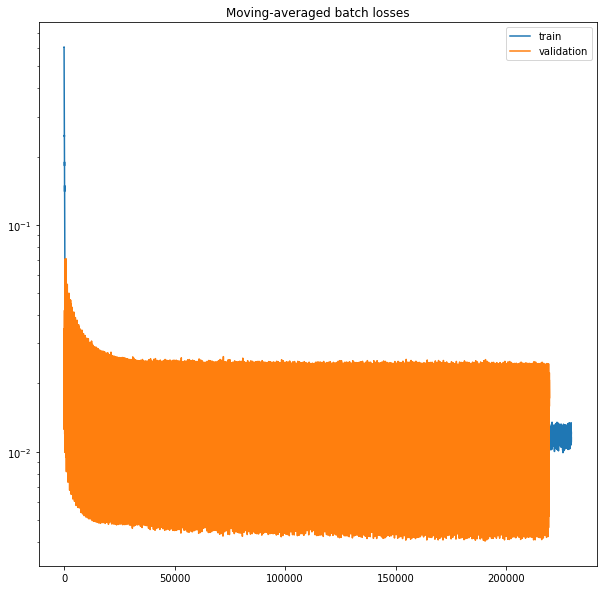

In [32]:
plt.figure(figsize=(10, 10))
plt.title('Moving-averaged batch losses')
plt.plot(np.arange(len(train_losses)), moving_average(train_losses), label='train')
plt.plot(np.arange(len(val_losses)), moving_average(val_losses), label='validation')

plt.legend(loc='best')
plt.yscale('log')

# plt.ylim([1e-2, 1])
plt.show()

In [33]:
mean_train_loss = [np.mean(item) for item in results['train_losses']]
mean_val_loss = [np.mean(item) for item in results['val_losses']]

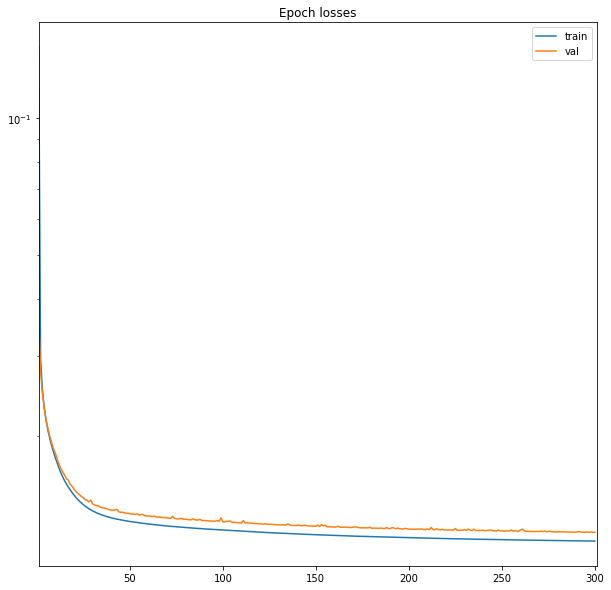

In [34]:
plt.figure(figsize=(10, 10))
plt.title('Epoch losses')
plt.plot(np.arange(len(mean_train_loss)) + 1, mean_train_loss, label='train')
plt.plot(np.arange(len(mean_val_loss)) + 1, mean_val_loss, label='val')

plt.yscale('log')
plt.legend(loc='best')

plt.xlim([1, len(mean_train_loss) + 1])
plt.show()

## Results

In [35]:
import pandas as pd

In [36]:
from visualization_utils import make_df

In [37]:
df = make_df(results, model_name='basic')
df

,accuracy,f1,iou,model,pr_auc,precision,recall,stack
0,0.996073,0.975523,0.952216,basic,0.998290,0.966575,0.984639,carb96558
1,0.988684,0.957214,0.917939,basic,0.995331,0.932186,0.983623,carb71
2,0.982819,0.896001,0.811595,basic,0.987084,0.986676,0.820589,carbRNF
3,0.992146,0.951330,0.907177,basic,0.997955,0.998958,0.908037,SPE_carb10_58_box3
4,0.990475,0.955501,0.914793,basic,0.996662,0.992191,0.921427,SoilAh-1
5,0.996216,0.974311,0.949909,basic,0.997919,0.975119,0.973504,SoilB-2
6,0.989772,0.961156,0.925217,basic,0.997864,0.995240,0.929329,TeTree_subset1
7,0.994019,0.968679,0.939261,basic,0.998485,0.996548,0.942327,TiTree_subset2
8,0.992429,0.968082,0.938139,basic,0.996876,0.968134,0.968030,Urna_22
9,0.990926,0.972627,0.946713,basic,0.997846,0.975201,0.970067,Urna_30


In [38]:
print('Mean   IOU: {:.5}'.format(df['iou'].mean()))
print('Std    IOU: {:.5}'.format(df['iou'].std()))
print('Min    IOU: {:.5}'.format(df['iou'].min()))
print('Median IOU: {:.5}'.format(df['iou'].median()))

Mean   IOU: 0.91946
Std    IOU: 0.039238
Min    IOU: 0.8116
Median IOU: 0.92522
